<a href="https://colab.research.google.com/github/VenkataramanSuriya/Automated-Cardiac-Diagnosis-Challenge-ACDC-/blob/main/Automated_Cardiac_Diagnosis_Challenge_(ACDC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Required Libraries**

In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib
from skimage import measure
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


**Encodeing the Img Data**

In [ ]:
def calculate_volume(segmented_data, voxel_volume):
    return np.sum(segmented_data) * voxel_volume

In [ ]:
def get_segmentations(data):
    """Return segmentation masks for LV, RV, MYO."""
    LV_seg = np.zeros(data.shape)
    RV_seg = np.zeros(data.shape)
    MYO_seg = np.zeros(data.shape)
    return LV_seg, RV_seg, MYO_seg

In [ ]:
def extract_features(file_path, patient_name):
    img = nib.load(file_path)
    data = img.get_fdata()

    ED_frame = 0
    ES_frame = 12


    LV_ED, RV_ED, MYO_ED = get_segmentations(data[:, :, :, ED_frame])
    LV_ES, RV_ES, MYO_ES = get_segmentations(data[:, :, :, ES_frame])

    voxel_volume = np.prod(img.header.get_zooms())

    features = {
        'Name': patient_name,
        'ED[vol(LV)]': calculate_volume(LV_ED, voxel_volume),
        'ES[vol(LV)]': calculate_volume(LV_ES, voxel_volume),
        'ED[vol(RV)]': calculate_volume(RV_ED, voxel_volume),
        'ES[vol(RV)]': calculate_volume(RV_ES, voxel_volume),
        'ED[mass(MYO)]': calculate_volume(MYO_ED, voxel_volume) * 1.05,
        'ES[vol(MYO)]': calculate_volume(MYO_ES, voxel_volume),
        'EF(LV)': ((calculate_volume(LV_ED, voxel_volume) - calculate_volume(LV_ES, voxel_volume)) / calculate_volume(LV_ED, voxel_volume)) * 100,
        'EF(RV)': ((calculate_volume(RV_ED, voxel_volume) - calculate_volume(RV_ES, voxel_volume)) / calculate_volume(RV_ED, voxel_volume)) * 100,
        'ED[vol(LV)/vol(RV)]': calculate_volume(LV_ED, voxel_volume) / calculate_volume(RV_ED, voxel_volume),
        'ES[vol(LV)/vol(RV)]': calculate_volume(LV_ES, voxel_volume) / calculate_volume(RV_ES, voxel_volume),
        'ED[mass(MYO)/vol(LV)]': (calculate_volume(MYO_ED, voxel_volume) * 1.05) / calculate_volume(LV_ED, voxel_volume),
        'ES[vol(MYO)/vol(LV)]': calculate_volume(MYO_ES, voxel_volume) / calculate_volume(LV_ES, voxel_volume),
        'GROUP': 'Unknown'
    }

    return features, data

In [ ]:
file_paths = [
    '/content/drive/MyDrive/ACDC dataset/Data/patient001_4d.nii',
    '/content/drive/MyDrive/ACDC dataset/Data/patient004_4d.nii',
    '/content/drive/MyDrive/ACDC dataset/Data/patient006_4d.nii',
    '/content/drive/MyDrive/ACDC dataset/Data/patient008_4d.nii',
    '/content/drive/MyDrive/ACDC dataset/Data/patient022_4d.nii',
    '/content/drive/MyDrive/ACDC dataset/Data/patient024_4d.nii',
    '/content/drive/MyDrive/ACDC dataset/Data/patient025_4d.nii',
    '/content/drive/MyDrive/ACDC dataset/Data/patient101_4d.nii',
    '/content/drive/MyDrive/ACDC dataset/Data/patient102_4d.nii',
    '/content/drive/MyDrive/ACDC dataset/Data/patient104_4d.nii',
]

In [ ]:
patient_names = [
    'patient001',
    'patient004',
    'patient006',
    'patient008',
    'patient022',
    'patient024',
    'patient025',
    'patient101',
    'patient102',
    'patient104'
]

all_features = []
all_images = []


In [ ]:
for file_path, patient_name in zip(file_paths, patient_names):
    features, data = extract_features(file_path, patient_name)
    all_features.append(features)
    all_images.append(data)


<ipython-input-19-b4dd675b22ec>:22: RuntimeWarning: invalid value encountered in scalar divide
  'EF(LV)': ((calculate_volume(LV_ED, voxel_volume) - calculate_volume(LV_ES, voxel_volume)) / calculate_volume(LV_ED, voxel_volume)) * 100,
<ipython-input-19-b4dd675b22ec>:23: RuntimeWarning: invalid value encountered in scalar divide
  'EF(RV)': ((calculate_volume(RV_ED, voxel_volume) - calculate_volume(RV_ES, voxel_volume)) / calculate_volume(RV_ED, voxel_volume)) * 100,
<ipython-input-19-b4dd675b22ec>:24: RuntimeWarning: invalid value encountered in scalar divide
  'ED[vol(LV)/vol(RV)]': calculate_volume(LV_ED, voxel_volume) / calculate_volume(RV_ED, voxel_volume),
<ipython-input-19-b4dd675b22ec>:25: RuntimeWarning: invalid value encountered in scalar divide
  'ES[vol(LV)/vol(RV)]': calculate_volume(LV_ES, voxel_volume) / calculate_volume(RV_ES, voxel_volume),
<ipython-input-19-b4dd675b22ec>:26: RuntimeWarning: invalid value encountered in scalar divide
  'ED[mass(MYO)/vol(LV)]': (calcula

In [ ]:
df = pd.DataFrame(all_features)

In [ ]:
output_csv_path = '/content/drive/MyDrive/extracted_features.csv'
df.to_csv(output_csv_path, index=False)

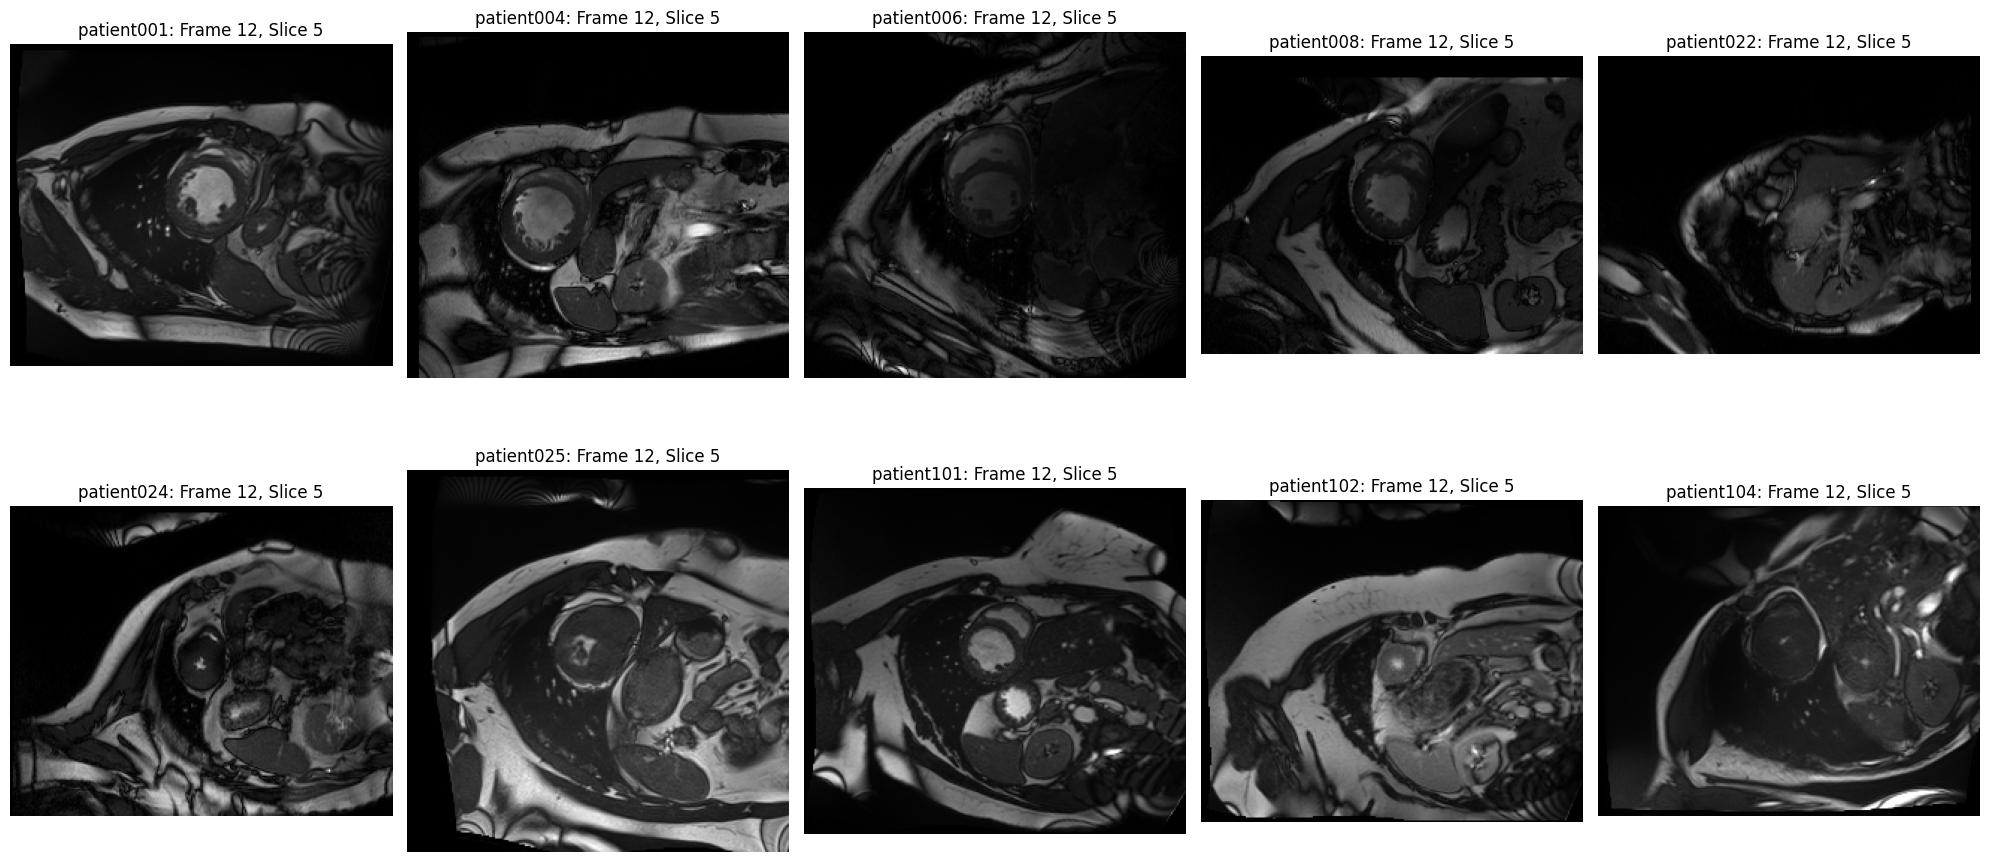

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
frame = 12  # Using the same frame for each image
slice_idx = 5

for i, ax in enumerate(axes.flat):
    img_data = all_images[i]
    ax.imshow(img_data[:, :, slice_idx, frame], cmap='gray')
    ax.set_title(f"{patient_names[i]}: Frame {frame}, Slice {slice_idx}")
    ax.axis('off')  # Hide axis ticks

plt.tight_layout()
plt.show()

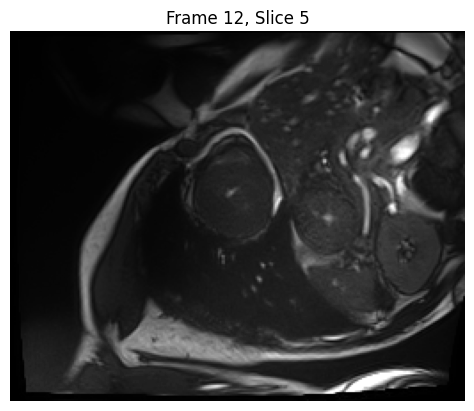

In [ ]:
frame = 12
slice_idx = 5

plt.imshow(data[:, :, slice_idx, frame], cmap='gray')
plt.title(f"Frame {frame}, Slice {slice_idx}")
plt.axis('off')
plt.show()

**Load and Explore the Dataset**

In [ ]:
file_path = '/content/Cardiac_parameters_train.csv'  # Update with correct path
data = pd.read_csv(file_path)

**Display the first few records of the dataset**

In [ ]:
print("First few records of the dataset:")
print(data.head())

First few records of the dataset:
         Name    ED[vol(LV)]    ES[vol(LV)]    ED[vol(RV)]    ES[vol(RV)]  \
0  patient014  334139.716217  286680.511726  240567.137375  181275.842911   
1  patient084   56637.018356   22056.660614  135984.920311   80936.729202   
2  patient092  116344.103565   45246.502190  215572.117910  125702.031584   
3  patient059  142695.378922   83198.471520  137199.905853   46692.828995   
4  patient012  308691.406250  233276.367188   99755.859375   51660.156250   

   ED[mass(MYO)]   ES[vol(MYO)]    EF(LV)    EF(RV)  ED[vol(LV)/vol(RV)]  ...  \
0  156359.293251  169275.524170  0.142034  0.246465             1.388967  ...   
1   32645.726917   40533.786900  0.610561  0.404811             0.416495  ...   
2   76533.977108   95943.537340  0.611098  0.416891             0.539699  ...   
3  126807.106445  141424.317123  0.416950  0.659673             1.040054  ...   
4  159985.351562  141650.390625  0.244306  0.482134             3.094469  ...   

   ES[vol(MYO)/v

**Display the last few records of the dataset**

In [ ]:
print("\nLast few records of the dataset:")
print(data.tail())



Last few records of the dataset:
          Name    ED[vol(LV)]    ES[vol(LV)]    ED[vol(RV)]    ES[vol(RV)]  \
65  patient048  158154.296875  106762.695312   71484.375000   25683.593750   
66  patient031  173096.679688   46887.695312  131893.676758   53784.240723   
67  patient067  143909.835815   57945.251465  189443.588257   96095.657349   
68  patient087  171939.085430   92163.193405  251923.869553  187292.654594   
69  patient070   89526.367188   33642.578125   96997.070312   36865.234375   

    ED[mass(MYO)]   ES[vol(MYO)]    EF(LV)    EF(RV)  ED[vol(LV)/vol(RV)]  \
65  130859.375000  153637.695312  0.324946  0.640710             2.212432   
66  187925.354004  208350.585938  0.729124  0.592215             1.312396   
67  108750.152588  126488.876343  0.597350  0.492748             0.759645   
68  109772.797222  149107.179176  0.463978  0.256551             0.682504   
69   65502.929688   89746.093750  0.624216  0.619935             0.922980   

    ...  ES[vol(MYO)/vol(LV)]  ES[

**Display summary info of the dataset**

In [ ]:
print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         70 non-null     object 
 1   ED[vol(LV)]                  70 non-null     float64
 2   ES[vol(LV)]                  70 non-null     float64
 3   ED[vol(RV)]                  70 non-null     float64
 4   ES[vol(RV)]                  70 non-null     float64
 5   ED[mass(MYO)]                70 non-null     float64
 6   ES[vol(MYO)]                 70 non-null     float64
 7   EF(LV)                       70 non-null     float64
 8   EF(RV)                       70 non-null     float64
 9   ED[vol(LV)/vol(RV)]          70 non-null     float64
 10  ES[vol(LV)/vol(RV)]          70 non-null     float64
 11  ED[mass(MYO)/vol(LV)]        70 non-null     float64
 12  ES[vol(MYO)/vol(LV)]         70 non-null     float64
 13  ES[max(

**Check for any missing values**

In [ ]:
print("\nChecking for missing values:")
print(data.isnull().sum())


Checking for missing values:
Name                           0
ED[vol(LV)]                    0
ES[vol(LV)]                    0
ED[vol(RV)]                    0
ES[vol(RV)]                    0
ED[mass(MYO)]                  0
ES[vol(MYO)]                   0
EF(LV)                         0
EF(RV)                         0
ED[vol(LV)/vol(RV)]            0
ES[vol(LV)/vol(RV)]            0
ED[mass(MYO)/vol(LV)]          0
ES[vol(MYO)/vol(LV)]           0
ES[max(mean(MWT|SA)|LA)]       0
ES[stdev(mean(MWT|SA)|LA)]     0
ES[mean(stdev(MWT|SA)|LA)]     0
ES[stdev(stdev(MWT|SA)|LA)]    0
ED[max(mean(MWT|SA)|LA)]       0
ED[stdev(mean(MWT|SA)|LA)]     0
ED[mean(stdev(MWT|SA)|LA)]     0
ED[stdev(stdev(MWT|SA)|LA)]    0
GROUP                          0
dtype: int64


**Descriptive statistics**

In [ ]:
print("\nDescriptive statistics:")
print(data.describe())


Descriptive statistics:
         ED[vol(LV)]    ES[vol(LV)]    ED[vol(RV)]    ES[vol(RV)]  \
count      70.000000      70.000000      70.000000      70.000000   
mean   168011.803131  101972.190473  155274.224101   87825.209613   
std     76529.285390   80973.235859   56769.692265   53257.411686   
min     49267.578125   19364.364624   47365.570068   10319.305420   
25%    118506.636655   45656.800470  115285.784330   52671.415733   
50%    148314.287977   66587.470505  149503.245066   70083.984375   
75%    201246.582342  127098.313121  182275.515669  115820.386063   
max    374376.417091  334457.137264  295117.187500  262817.382812   

       ED[mass(MYO)]   ES[vol(MYO)]     EF(LV)     EF(RV)  \
count      70.000000      70.000000  70.000000  70.000000   
mean   125576.089783  142267.179552   0.459752   0.464695   
std     50192.264968   57241.750946   0.195923   0.175682   
min     32645.726917   40533.786900   0.104767   0.019169   
25%     92153.058855   98336.855355   0.276259  

### **Data Preprocessing**

**Encode the target variable (GROUP)**

In [ ]:
label_encoder = LabelEncoder()
data['GROUP_encoded'] = label_encoder.fit_transform(data['GROUP'])


**Split features (X) and target (y)**

In [ ]:
X = data.drop(columns=['Name', 'GROUP', 'GROUP_encoded'])  # Dropping unnecessary columns
y = data['GROUP_encoded']  # Target variable


**Split the dataset into training and testing sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


**Standardize the features using StandardScaler**

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Data Exploration Using Various Methods**

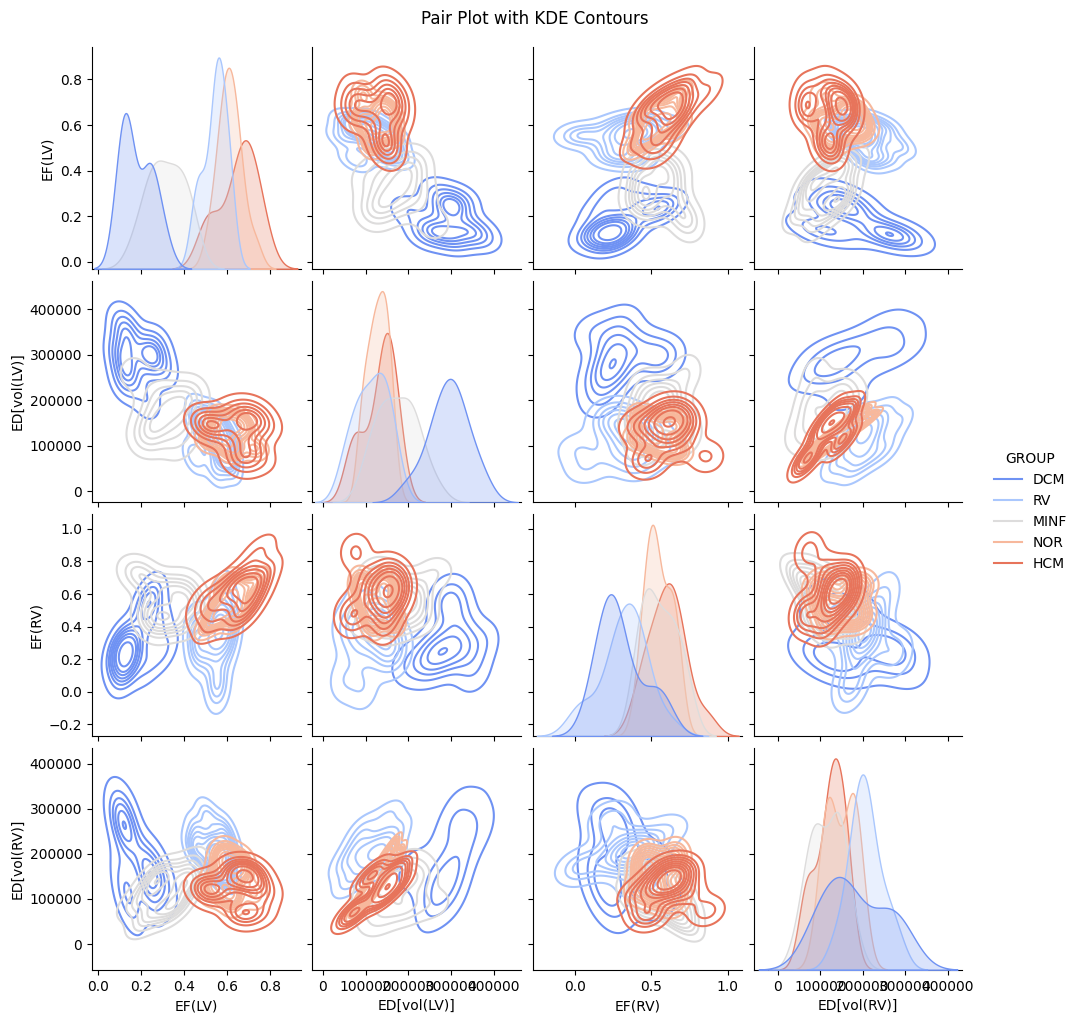

In [ ]:
sns.pairplot(data[['EF(LV)', 'ED[vol(LV)]', 'EF(RV)', 'ED[vol(RV)]', 'GROUP']],
             hue='GROUP', diag_kind='kde', kind='kde', palette='coolwarm')
plt.suptitle('Pair Plot with KDE Contours', y=1.02)
plt.show()

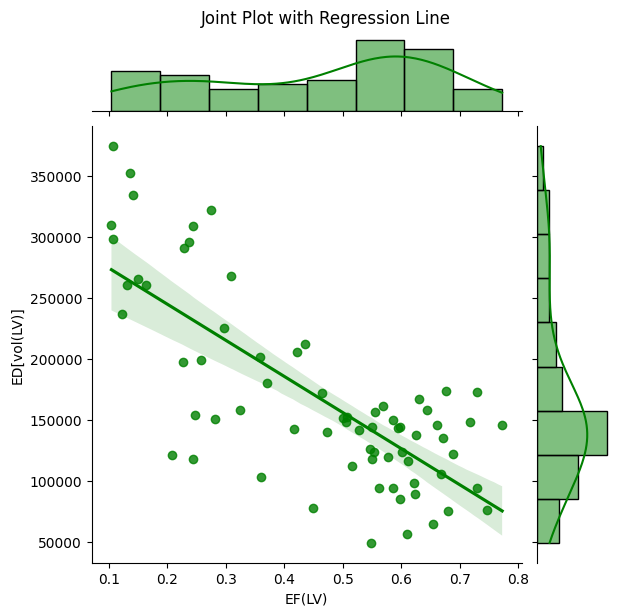

In [ ]:
sns.jointplot(x='EF(LV)', y='ED[vol(LV)]', data=data, kind='reg', color='green')
plt.suptitle('Joint Plot with Regression Line', y=1.02)
plt.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
features = ['EF(LV)', 'ED[vol(LV)]', 'EF(RV)', 'ED[vol(RV)]', 'ED[mass(MYO)]']
grouped_data = data.groupby('GROUP')[features].mean()

In [ ]:
fig = go.Figure()
for i, group in enumerate(grouped_data.index):
    fig.add_trace(go.Scatterpolar(
        r=grouped_data.loc[group],
        theta=features,
        fill='toself',
        name=group
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1])
    ),
    showlegend=True,
    title="Radar Chart for Cardiac Parameters by Group"
)
fig.show()

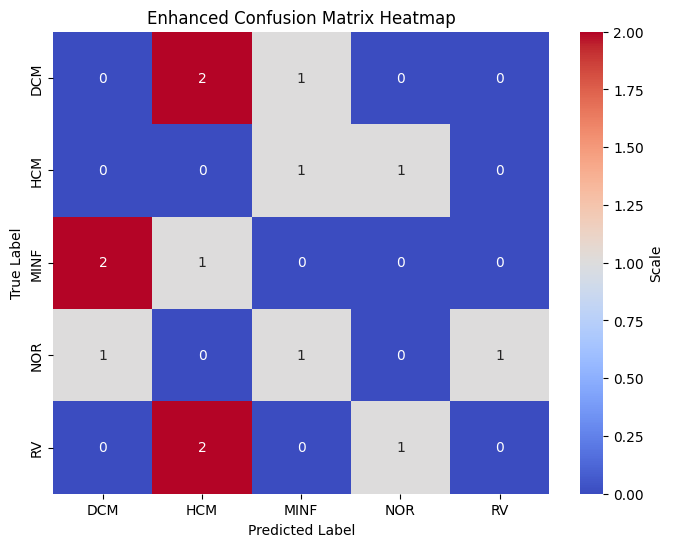

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = np.random.randint(0, 5, len(y_test))  # Dummy predictions for now

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            cbar_kws={'label': 'Scale'},
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Enhanced Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

<ipython-input-43-8dde0947675b>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




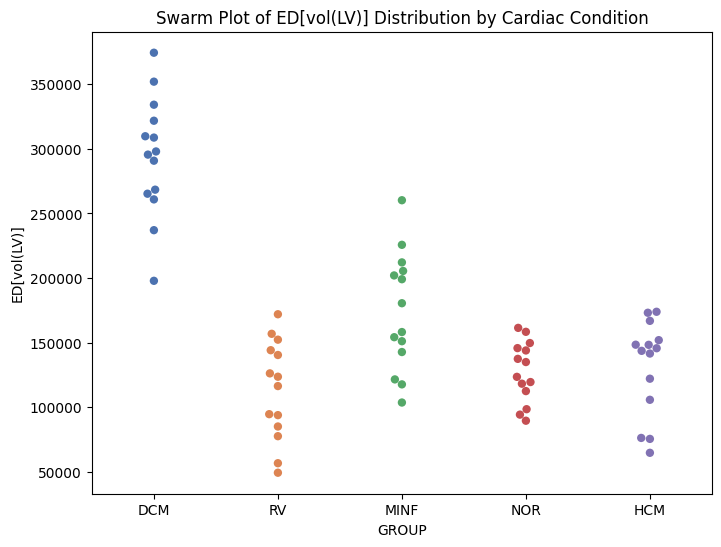

In [ ]:
plt.figure(figsize=(8, 6))
sns.swarmplot(x='GROUP', y='ED[vol(LV)]', data=data, palette='deep', size=6)
plt.title('Swarm Plot of ED[vol(LV)] Distribution by Cardiac Condition')
plt.show()

<ipython-input-44-343b9b19aab3>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




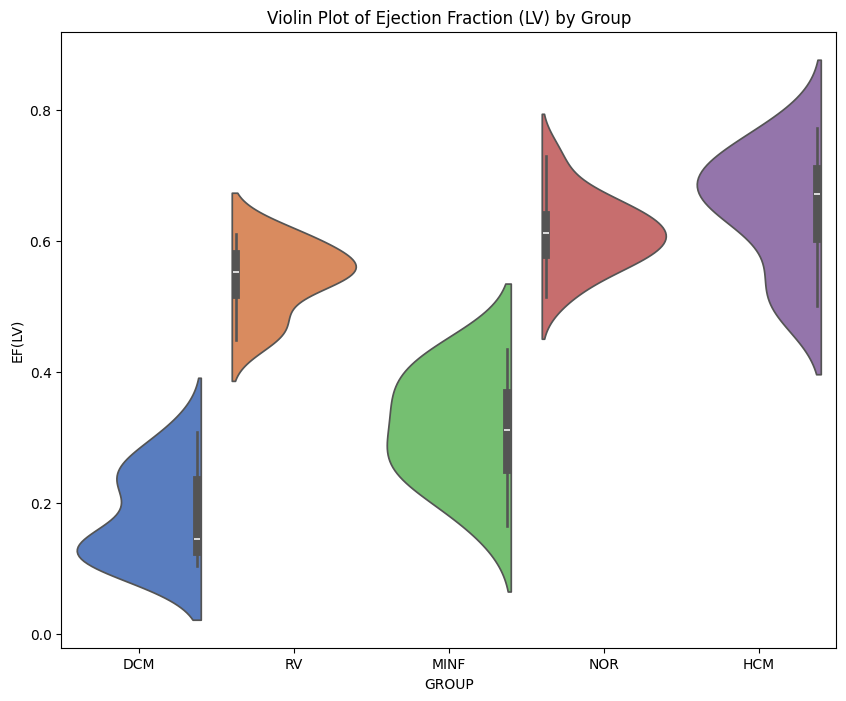

In [ ]:
plt.figure(figsize=(10, 8))
sns.violinplot(x='GROUP', y='EF(LV)', data=data, palette='muted', split=True)
plt.title('Violin Plot of Ejection Fraction (LV) by Group')
plt.show()

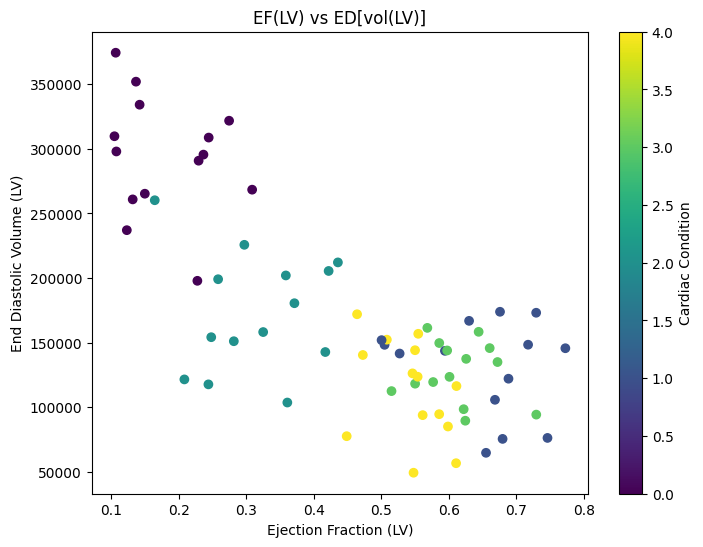

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data['EF(LV)'], data['ED[vol(LV)]'], c=data['GROUP_encoded'], cmap='viridis')
plt.xlabel('Ejection Fraction (LV)')
plt.ylabel('End Diastolic Volume (LV)')
plt.title('EF(LV) vs ED[vol(LV)]')
plt.colorbar(label='Cardiac Condition')
plt.show()

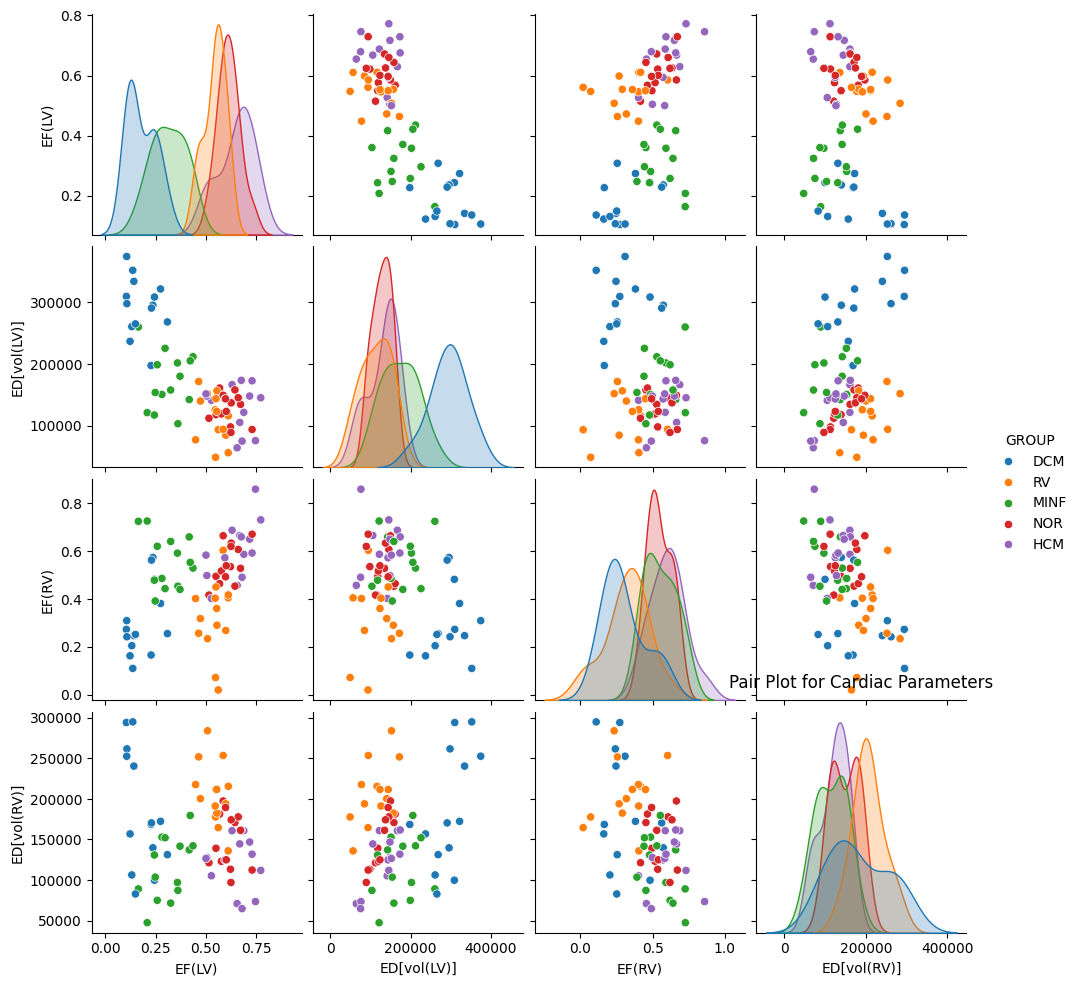

In [ ]:
sns.pairplot(data[['EF(LV)', 'ED[vol(LV)]', 'EF(RV)', 'ED[vol(RV)]', 'GROUP']], hue='GROUP', diag_kind='kde')
plt.title('Pair Plot for Cardiac Parameters')
plt.show()


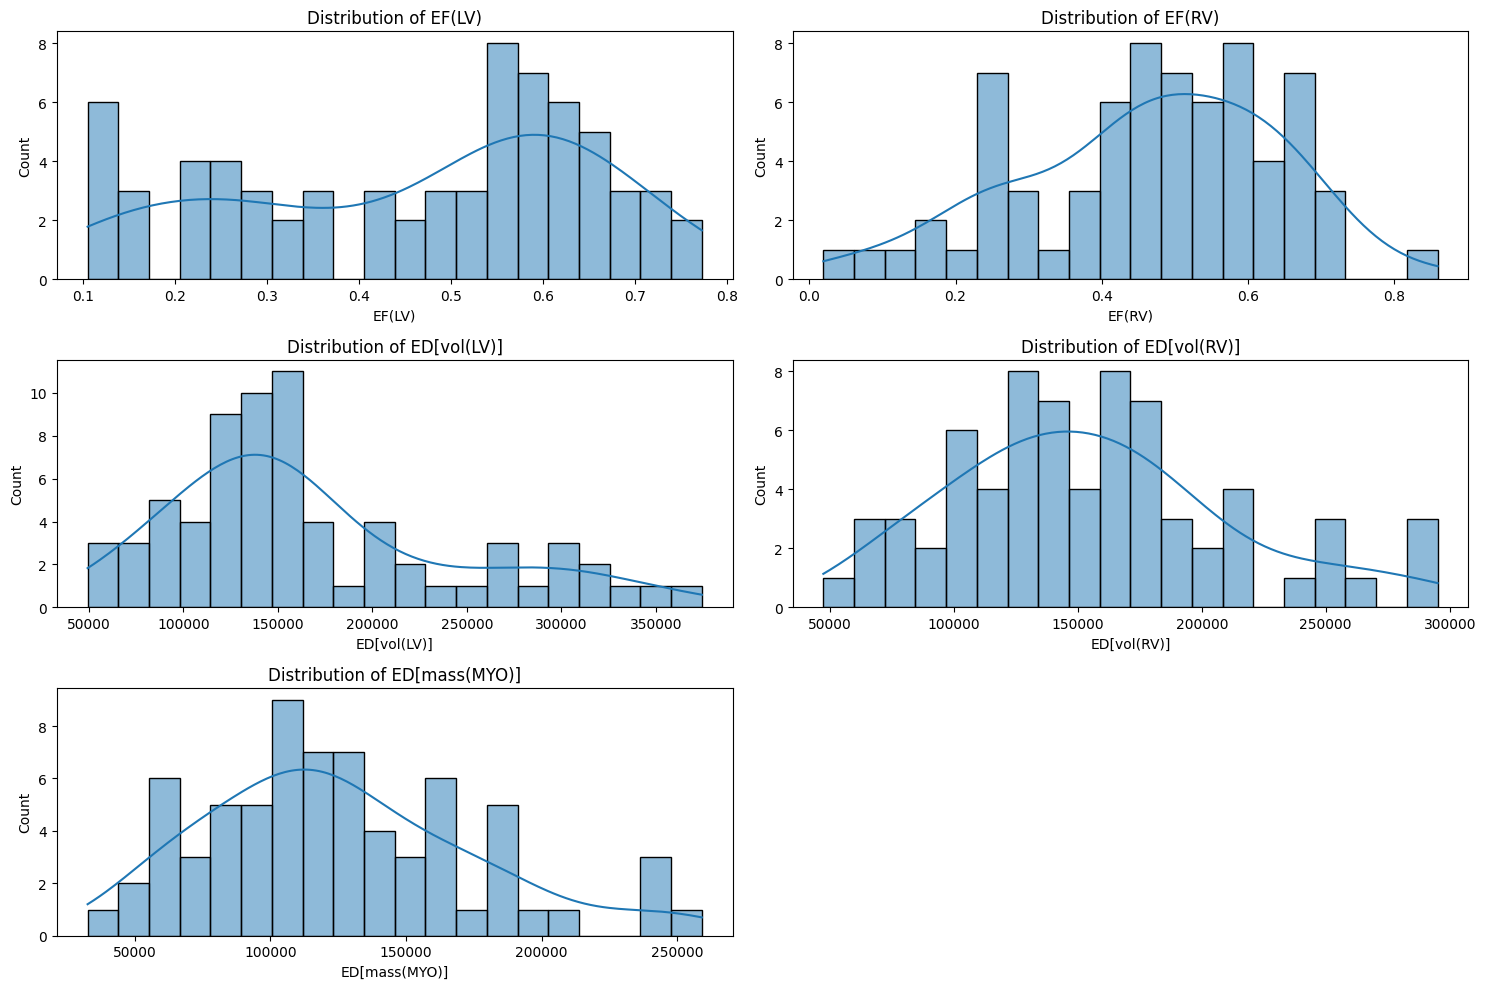

In [ ]:
selected_features = ['EF(LV)', 'EF(RV)', 'ED[vol(LV)]', 'ED[vol(RV)]', 'ED[mass(MYO)]']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[feature], kde=True, bins=20)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


### **Building the Deep Learning Model**

**Layers**

In [ ]:
model = Sequential()


**Input layer**

In [ ]:
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



**Hidden layers with dropout**

In [ ]:
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

**Output layer**

In [ ]:
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

**Compile the model**

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


**Train the Model**

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.2515 - loss: 1.7169 - val_accuracy: 0.2857 - val_loss: 1.5620
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3765 - loss: 1.5125 - val_accuracy: 0.5000 - val_loss: 1.4587
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4435 - loss: 1.3315 - val_accuracy: 0.5714 - val_loss: 1.3710
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5893 - loss: 1.2329 - val_accuracy: 0.7143 - val_loss: 1.2812
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5893 - loss: 1.1819 - val_accuracy: 0.7857 - val_loss: 1.1869
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6711 - loss: 1.0341 - val_accuracy: 0.8571 - val_loss: 1.0874
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7723 - loss: 0.9195 - val_accuracy: 0.8571 - val_loss: 0.9725
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8065 - loss: 0.8294 - val_accuracy: 0.9286 - val_loss

**Evaluate on test data**

In [ ]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')


1/1 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.0094

Test accuracy: 1.0


**Predictions on the test data**

In [ ]:
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


**Classification Report**

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

         DCM       1.00      1.00      1.00         3
         HCM       1.00      1.00      1.00         2
        MINF       1.00      1.00      1.00         3
         NOR       1.00      1.00      1.00         3
          RV       1.00      1.00      1.00         3

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



**Confusion Matrix**

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[3 0 0 0 0]
 [0 2 0 0 0]
 [0 0 3 0 0]
 [0 0 0 3 0]
 [0 0 0 0 3]]


**Accuracy**

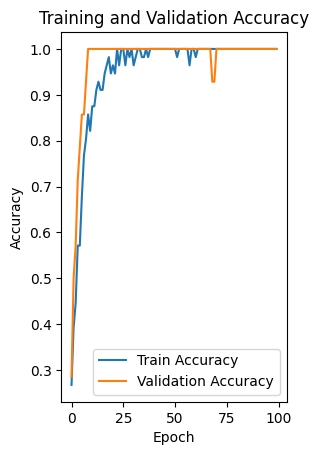

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

**Loss**

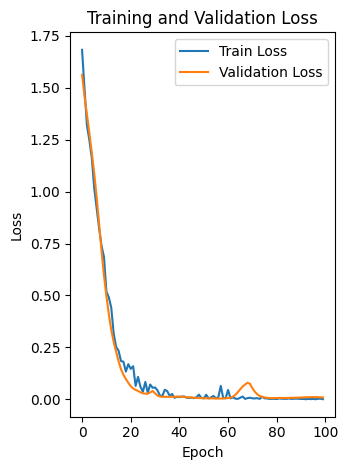

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Confusion Matrix Visualization**

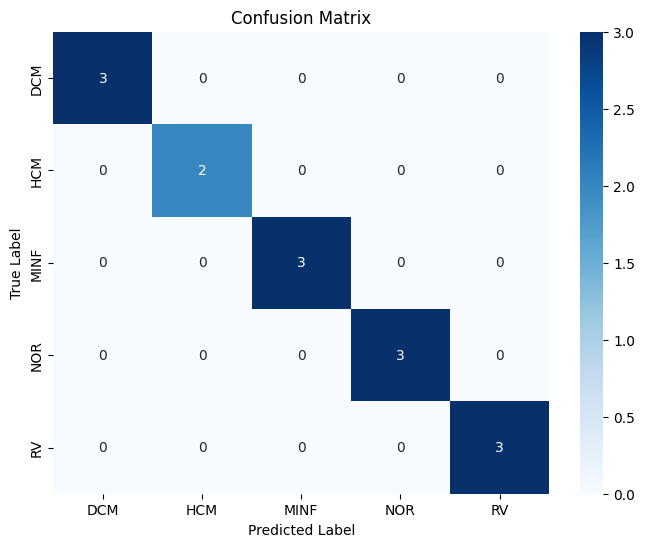

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**Additional Plot: Precision, Recall, and F1-Score Visualization**

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)

plt.figure(figsize=(14, 6))
x_labels = label_encoder.classes_

<Figure size 1400x600 with 0 Axes>

**Plot Precision**

Text(0.5, 1.0, 'Class-wise Precision')

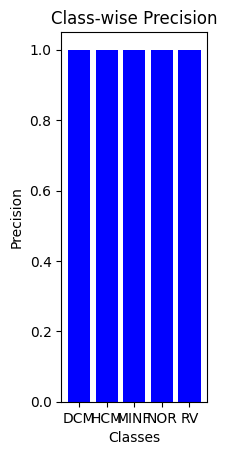

In [ ]:
plt.subplot(1, 3, 1)
plt.bar(x_labels, precision, color='blue')
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Class-wise Precision')

**Plot Recall**

Text(0.5, 1.0, 'Class-wise Recall')

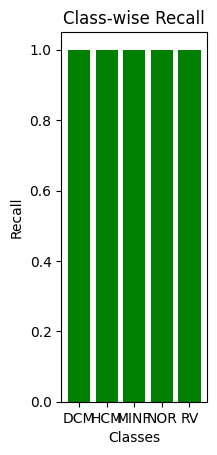

In [ ]:
plt.subplot(1, 3, 2)
plt.bar(x_labels, recall, color='green')
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Class-wise Recall')

**Plot F1-Score**

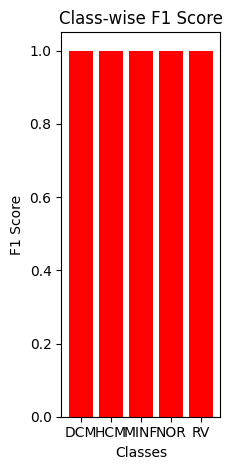

In [ ]:
plt.subplot(1, 3, 3)
plt.bar(x_labels, f1, color='red')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title('Class-wise F1 Score')

plt.tight_layout()
plt.show()


**Save the Model**

In [ ]:
model.save("cardiac_classification_model_extended.h5")
print("Model saved successfully!")


Model saved successfully!
